In [1]:
using Turing
using DataFrames
using CSV
using Random
using Distributions
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using Logging
using LinearAlgebra

default(label=false);
Logging.disable_logging(Logging.Warn);

# 14.1 Varying slopes by construction

Code 14.1

In [2]:
a = 3.5    # average morning wait time
b = -1     # average difference afternoon wait time
σ_a = 1    # std dev in intercepts
σ_b = 0.5  # std dev in slopes
ρ = -0.7;  # correlation between intercepts and slopes

Code 14.2

In [3]:
μ = [a, b];

Code 14.3

In [4]:
cov_ab = σ_a * σ_b * ρ
Σ = [[σ_a^2, cov_ab] [cov_ab, σ_b^2]]

2×2 Matrix{Float64}:
  1.0   -0.35
 -0.35   0.25

Code 14.4

Julia has similar "column-first" matix order

In [5]:
reshape(1:4, (2,2))

2×2 reshape(::UnitRange{Int64}, 2, 2) with eltype Int64:
 1  3
 2  4

Code 14.5

In [6]:
sigmas = [σ_a, σ_b]
Ρ = [[1, ρ] [ρ, 1]]
Σ = Diagonal(sigmas) * Ρ * Diagonal(sigmas);

Code 14.6

In [7]:
N_cafes = 20;

Code 14.7

In [8]:
Random.seed!(5)
vary_effect = rand(MvNormal(μ, Σ), N_cafes);

Code 14.8

In [9]:
a_cafe = vary_effect[1,:]
b_cafe = vary_effect[2,:];

Code 14.9

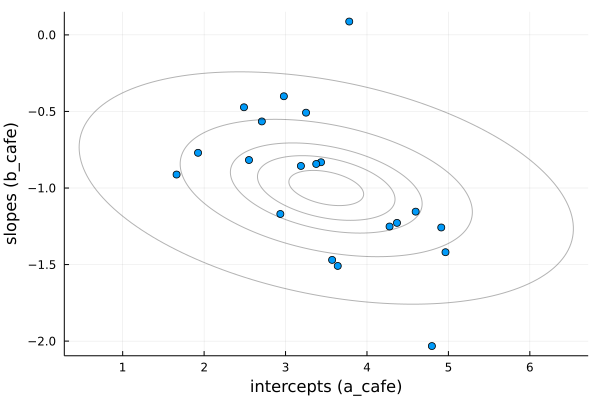

In [10]:
p = scatter(a_cafe, b_cafe, xlab="intercepts (a_cafe)", ylab="slopes (b_cafe)")

d = acos(Σ[1,2])
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*Σ[1,1]*cos(t + d/2) + μ[1]
    yₜ(t) = scale*Σ[2,2]*cos(t - d/2) + μ[2]

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end
p

Code 14.10

In [11]:
Random.seed!(22)
N_visits = 10

afternoon = repeat(0:1, N_visits*N_cafes ÷ 2)
cafe_id = repeat(1:N_cafes, inner=N_visits)
μ = a_cafe[cafe_id] + b_cafe[cafe_id] .* afternoon
σ = 0.5
wait = rand.(Normal.(μ, σ))
d = DataFrame(cafe=cafe_id, afternoon=afternoon, wait=wait);

Code 14.11

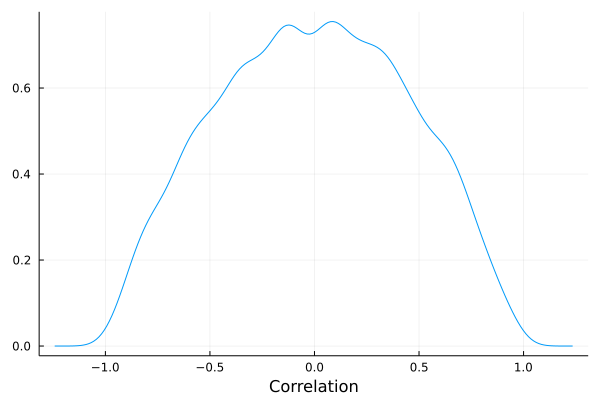

In [12]:
R = rand(LKJ(2, 2), 10^4);
density(getindex.(R, 2), xlab="Correlation")

Code 14.12

In [13]:
@model function m14_1(cafe, afternoon, wait)
    a ~ Normal(5, 2)
    b ~ Normal(-1, 0.5)
    σ_cafe ~ filldist(Exponential(), 2)
    Rho ~ LKJ(2, 2)
    # build sigma matrix manually, to avoid numerical errors
    (σ₁, σ₂) = σ_cafe
    sc = [[σ₁^2, σ₁*σ₂] [σ₁*σ₂, σ₂^2]]
    Σ = Rho .* sc
    ab ~ filldist(MvNormal([a,b], Σ), N_cafes)
    a = ab[1,cafe]
    b = ab[2,cafe]
    μ = @. a + b * afternoon
    σ ~ Exponential()
    for i ∈ eachindex(wait)
        wait[i] ~ Normal(μ[i], σ)
    end
end

Random.seed!(1)
m14_1_ch = sample(m14_1(d.cafe, d.afternoon, d.wait), NUTS(), 1000)
m14_1_df = DataFrame(m14_1_ch);

Code 14.13

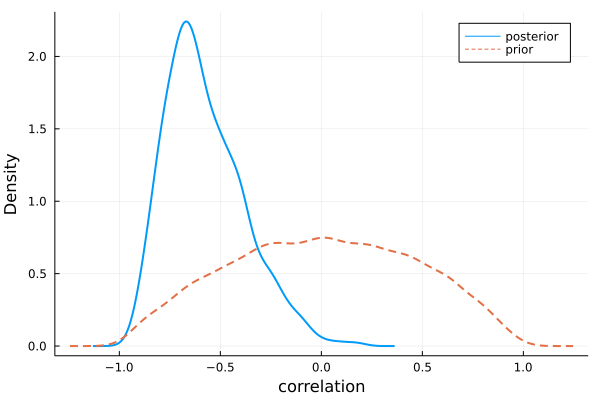

In [14]:
density(m14_1_df."Rho[1,2]", lab="posterior", lw=2)

R = rand(LKJ(2, 2), 10^4);
density!(getindex.(R, 2), lab="prior", ls=:dash, lw=2)
plot!(xlab="correlation", ylab="Density")

Code 14.14

Something is weird with the plot. Maybe my version of the model is just wrong

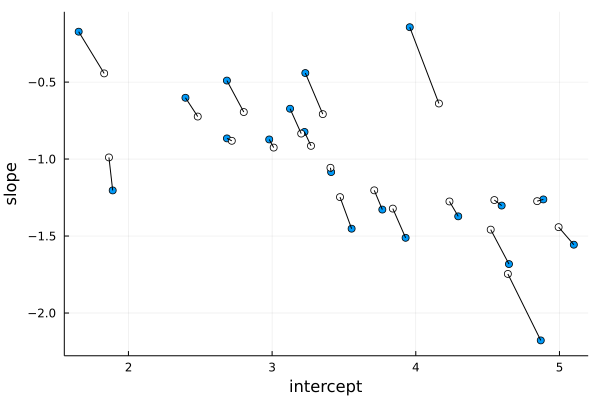

In [15]:
gb = groupby(d[d.afternoon .== 0,:], :cafe)
a1 = combine(gb, :wait => mean).wait_mean

gb = groupby(d[d.afternoon .== 1,:], :cafe)
b1 = combine(gb, :wait => mean).wait_mean .- a1

a2 = [mean(m14_1_df[:, "ab[1,$i]"]) for i ∈ 1:N_cafes]
b2 = [mean(m14_1_df[:, "ab[2,$i]"]) for i ∈ 1:N_cafes]

xlim = extrema(a1) .+ (-0.1, 0.1)
ylim = extrema(b1) .+ (-0.1, 0.1)

p = scatter(a1, b1, xlab="intercept", ylab="slope", xlim=xlim, ylim=ylim)
scatter!(a2, b2, mc=:white)

for (x1,y1,x2,y2) ∈ zip(a1, b1, a2, b2)
    plot!([x1,x2], [y1,y2], c=:black)
end
p

Code 14.15

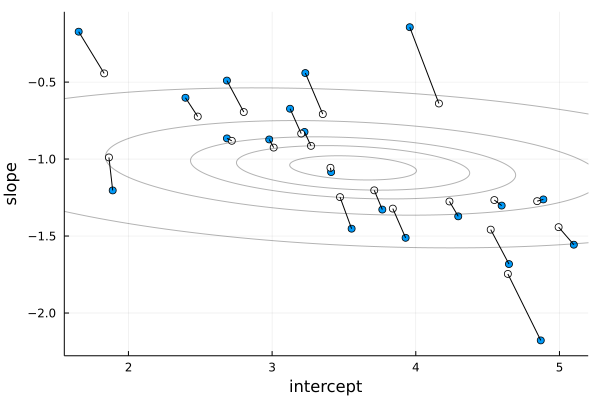

In [16]:
# posterior mean
ρ = mean(m14_1_df."Rho[1,2]")
μ_a = mean(m14_1_df.a)
μ_b = mean(m14_1_df.b)
σ₁ = mean(m14_1_df."σ_cafe[1]")
σ₂ = mean(m14_1_df."σ_cafe[2]")

# draw ellipses
dt = acos(ρ*σ₁*σ₂)
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*σ₁^2*cos(t + dt/2) + μ_a
    yₜ(t) = scale*σ₂^2*cos(t - dt/2) + μ_b

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end

p

Code 14.16

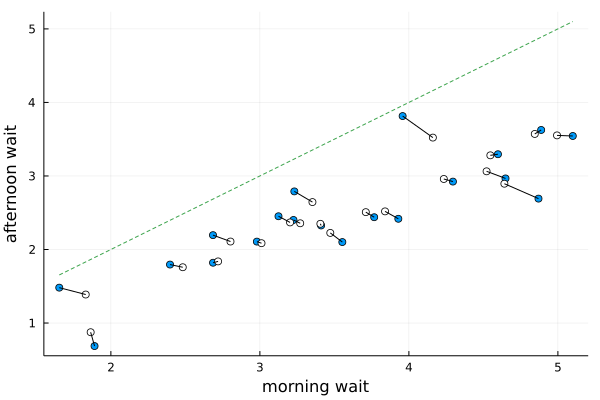

In [17]:
wait_morning_1 = a1
wait_afternoon_1 = a1 .+ b1
wait_morning_2 = a2
wait_afternoon_2 = a2 .+ b2

p = scatter(wait_morning_1, wait_afternoon_1, xlab="morning wait", ylab="afternoon wait")
scatter!(wait_morning_2, wait_afternoon_2, mc=:white)

plot!(x -> x, s=:dash)

for (x1,y1,x2,y2) ∈ zip(wait_morning_1, wait_afternoon_1, wait_morning_2, wait_afternoon_2)
    plot!([x1,x2], [y1,y2], c=:black)
end
p

Code 14.17

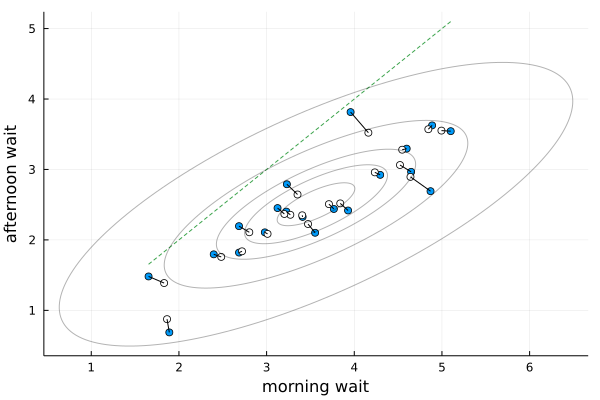

In [18]:
Random.seed!(1)

Σ = [[σ₁^2, σ₁*σ₂*ρ] [σ₁*σ₂*ρ, σ₂^2]]
μ = [μ_a, μ_b]
v = rand(MvNormal(μ, Σ), 10^4)
v[2,:] += v[1,:]
Σ₂ = cov(v')
μ₂ = [μ_a, μ_a+μ_b]

# draw ellipses
dt = acos(Σ₂[1,2])
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*Σ₂[1,1]*cos(t + dt/2) + μ₂[1]
    yₜ(t) = scale*Σ₂[2,2]*cos(t - dt/2) + μ₂[2]

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end

p

# 14.2 Advanced varying slopes